In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/finger-gesture/Finger_gesture/train/three/170.jpg
/kaggle/input/finger-gesture/Finger_gesture/train/three/87.jpg
/kaggle/input/finger-gesture/Finger_gesture/train/three/167.jpg
/kaggle/input/finger-gesture/Finger_gesture/train/three/138.jpg
/kaggle/input/finger-gesture/Finger_gesture/train/three/163.jpg
/kaggle/input/finger-gesture/Finger_gesture/train/three/148.jpg
/kaggle/input/finger-gesture/Finger_gesture/train/three/38.jpg
/kaggle/input/finger-gesture/Finger_gesture/train/three/184.jpg
/kaggle/input/finger-gesture/Finger_gesture/train/three/99.jpg
/kaggle/input/finger-gesture/Finger_gesture/train/three/90.jpg
/kaggle/input/finger-gesture/Finger_gesture/train/three/76.jpg
/kaggle/input/finger-gesture/Finger_gesture/train/three/73.jpg
/kaggle/input/finger-gesture/Finger_gesture/train/three/97.jpg
/kaggle/input/finger-gesture/Finger_gesture/train/three/106.jpg
/kaggle/input/finger-gesture/Finger_gesture/train/three/42.jpg
/kaggle/input/finger-gesture/Finger_gesture/trai

In [2]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D,MaxPooling2D,ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras

Using TensorFlow backend.


In [3]:
#Using Transfer learning VGG16 pretrained model 
row,col = 128,128
vgg = VGG16(input_shape=(row,col,3), weights='imagenet', include_top=False)

vgg_output = vgg.layers[-1].output
vgg_output = keras.layers.Flatten()(vgg_output)

model_vgg = Model(vgg.input, output=vgg_output)

# existing weights are not trained
for layer in model_vgg.layers:
    layer.trainable = False

model_vgg.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
____________________________________________________________

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  


In [4]:
#Adding new layers on VGG16model
num_class = 6
input_shape = model_vgg.output_shape[1]
model = Sequential()
model.add(model_vgg)

model.add(Dense(512,kernel_initializer = 'he_uniform', activation='relu', input_dim=input_shape))
model.add(Dropout(0.4))
model.add(Dense(256,kernel_initializer = 'he_uniform', activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128,kernel_initializer = 'he_uniform', activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_class, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8192)              14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [5]:
#Applying Augmentation

batch_size = 32
train_data_dir = '../input/finger-gesture/Finger_gesture/train/'
validation_data_dir = '../input/finger-gesture/Finger_gesture/test/'

train_datagen = ImageDataGenerator(
                rescale = 1./255,
                rotation_range = 30,
                shear_range = 0.3,
                zoom_range = 0.3,
                horizontal_flip = True,
                fill_mode = 'nearest'
                )

validation_datagen = ImageDataGenerator(
                    rescale = 1./255
                    )

train_dataset = train_datagen.flow_from_directory(
                train_data_dir,
                target_size = (row, col),
                batch_size = batch_size,
                class_mode = 'categorical',
                shuffle = True
                )

validation_dataset = train_datagen.flow_from_directory(
                    validation_data_dir,
                    target_size = (row, col),
                    batch_size = batch_size,
                    class_mode = 'categorical',
                    shuffle = True
                    )

Found 1200 images belonging to 6 classes.
Found 300 images belonging to 6 classes.


In [6]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

checkpoint = ModelCheckpoint(
                             'finger_sign.hdf5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(
                          monitor='val_loss',
                          patience=9,
                          min_delta=0,
                          restore_best_weights=True,
                          verbose=1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0001)

model_callbacks = [earlystop,checkpoint,learning_rate_reduction]

In [7]:
from keras.optimizers import Adam, RMSprop, SGD

opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy']
              )

In [8]:
batch_size = 32

history = model.fit_generator(train_dataset,
                    steps_per_epoch = train_dataset.n//batch_size,
                    epochs = 20,
                    callbacks = model_callbacks,
                    validation_data = validation_dataset,
                    validation_steps = validation_dataset.n//batch_size)

Epoch 1/20
37/37 [==============================] - 13s 364ms/step - loss: 1.9550 - accuracy: 0.3493 - val_loss: 1.1008 - val_accuracy: 0.5243

Epoch 00001: val_loss improved from inf to 1.10081, saving model to finger_sign.hdf5
Epoch 2/20
37/37 [==============================] - 10s 279ms/step - loss: 0.8868 - accuracy: 0.6301 - val_loss: 0.8373 - val_accuracy: 0.4925

Epoch 00002: val_loss improved from 1.10081 to 0.83729, saving model to finger_sign.hdf5
Epoch 3/20
37/37 [==============================] - 10s 280ms/step - loss: 0.4666 - accuracy: 0.8168 - val_loss: 0.9853 - val_accuracy: 0.6119

Epoch 00003: val_loss did not improve from 0.83729
Epoch 4/20
37/37 [==============================] - 10s 268ms/step - loss: 0.2692 - accuracy: 0.8981 - val_loss: 0.8408 - val_accuracy: 0.5485

Epoch 00004: val_loss did not improve from 0.83729
Epoch 5/20
37/37 [==============================] - 10s 263ms/step - loss: 0.1390 - accuracy: 0.9503 - val_loss: 0.8689 - val_accuracy: 0.6828

Epoc

In [9]:
from keras.models import load_model
import cv2
import numpy as np
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from time import sleep

Gesture Prediction: two


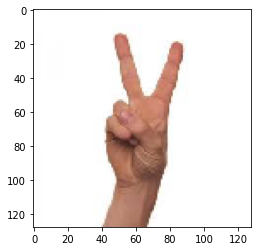

In [10]:
import numpy as np
import matplotlib.pyplot as plt

classifier = load_model('/kaggle/working/finger_sign.hdf5')
class_labels = ['five','four','none','one','three','two']

from skimage import io
img = image.load_img('../input/testdata/one.jpg', color_mode = "rgb", target_size=(128, 128))
show_img=image.load_img('../input/testdata/one.jpg', grayscale=False, target_size=(128, 128))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

pred = classifier.predict(x)[0]
label = class_labels[pred.argmax()]

plt.imshow(show_img)
print('Gesture Prediction:',label)